## R peak detection experiments

In [1]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 5]  # Bigger images

{'A00001': 14.31409788166545, 'A00002': 113.21875, 'A00003': 23.639710716633793, 'A00004': 103.00832342449466, 'A00005': 107.9775377229081, 'A00006': 17.84087791495198, 'A00007': 19.188775510204085}


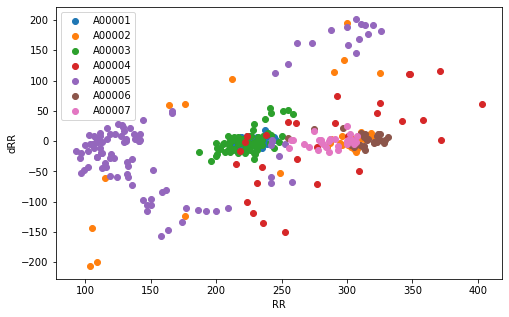

In [2]:
spread_data = {}
for i in range(1,8):
    # Retrieve ECG data from data folder (sampling rate= 1000 Hz)
    ecg_signal = scipy.io.loadmat(f"2_data\\physionet_datasets\\training2017\\A0000{i}.mat")['val'][0]
    # ecg_signal = nk.data(dataset="ecg_3000hz")['ECG'] 
    # ecg_signal += np.random.randn((ecg_signal.size))*0.01
    ecg_signal = ecg_signal / np.max(ecg_signal)

    # Extract R-peaks locations
    _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=300)
    
    # Calculate the RR and dRR values
    R_peaks = rpeaks['ECG_R_Peaks']
    RR = (np.pad(R_peaks, (0,1))[1:] - R_peaks)[:-1]
    dRR = (np.pad(RR, (0,1))[1:] - RR)[:-1]
    RR = RR[1:]
    
    # Calculate the spread of the points around mean point 
    RR_dRR_arr = np.vstack((RR,dRR)).T
    centre_point = np.mean(RR_dRR_arr, axis=0)
    spread = np.mean(np.linalg.norm(RR_dRR_arr - centre_point, ord=1, axis=1))
    spread_data[f'A0000{i}'] = spread
    
    plt.scatter(RR,dRR, label=f'A0000{i}')
        
    
    # Visualize R-peaks in ECG signal
    # plot = nk.events_plot(rpeaks['ECG_R_Peaks'], ecg_signal)

    # Zooming into the first 5 R-peaks
    # plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:5], ecg_signal[:4*300])

print(spread_data)
plt.xlabel('RR')
plt.ylabel('dRR')
plt.legend()

It seems as though A00002, A00004 and A00005

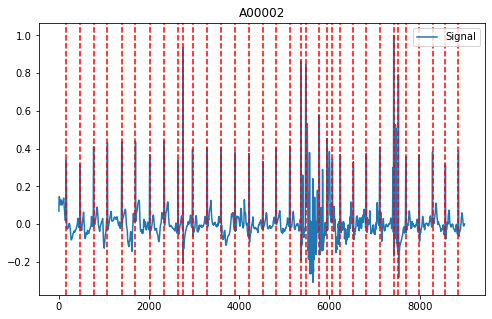

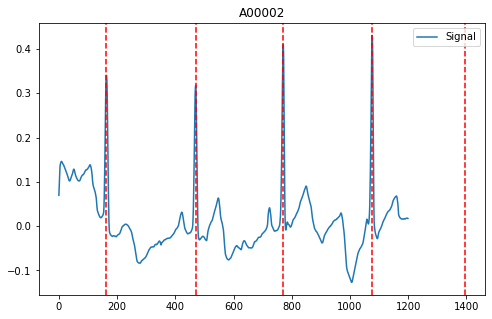

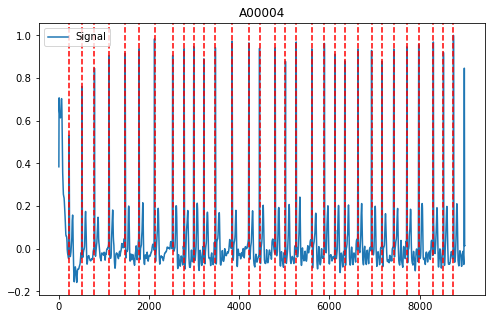

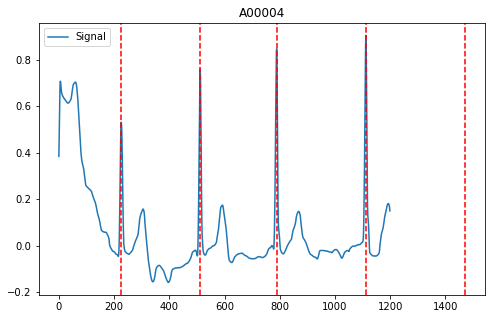

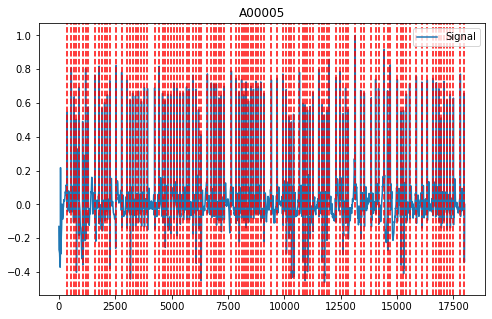

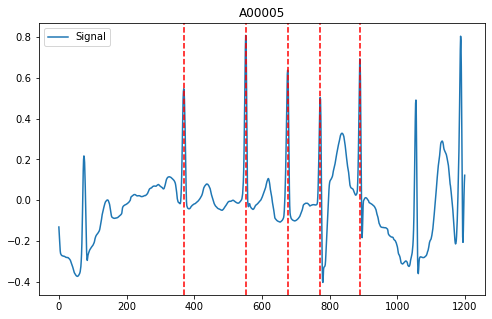

In [3]:
threshold = 50
for key, val in spread_data.items():
    if val > threshold:
        ecg_signal = scipy.io.loadmat(f"2_data\\physionet_datasets\\training2017\\{key}.mat")['val'][0]
        # ecg_signal = nk.data(dataset="ecg_3000hz")['ECG'] 
        # ecg_signal += np.random.randn((ecg_signal.size))*0.01
        ecg_signal = ecg_signal / np.max(ecg_signal)
    
        # Extract R-peaks locations
        _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=300)
    
        
        # Visualize R-peaks in ECG signal
        plot = nk.events_plot(rpeaks['ECG_R_Peaks'], ecg_signal)
        plt.title(key)
        
        # Zooming into the first 5 R-peaks
        plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:5], ecg_signal[:4*300])
        plt.title(key)

Taking the spread as the average of the norm values for vectors from each point to the mean point in the data is unable to distinguish between samples of AF or ventricular bigeminy ventricular trigeminy, using a thresholding approach.

Attempt will be made at using the infinite norm of subsample of RR,dRR values from the entire sample, and finding the preportion of them over a certain threshold. 